In [1]:
import yaml
import healpy as hp
import numpy as np
import os
import scipy

from plancklens import utils

from jointmap.plots import CMBLensingPlot 

from delensalot.core import cachers

import os
import numpy as np

from delensalot.core.iterator import statics

import yaml

import matplotlib.pyplot as plt



mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map


In [2]:
def bin_theory(cl, bin_edges):
    l = np.arange(len(cl))
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, l*cl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    el = (bin_edges[1:] + bin_edges[:-1])/2
    return el, cl


bin_edges = np.arange(10, 4000, 20)


def cross_corr_coeff(a, b, base=0, color=None, plot=True, ax=None, label=None):
    ls = np.arange(len(hp.alm2cl(a)))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(hp.alm2cl(a, b))
    el, aa = decorator(hp.alm2cl(a, a))
    el, bb = decorator(hp.alm2cl(b, b))
    xcorr = np.sqrt(x**2 / (aa * bb))
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label)
    return el, xcorr


def cross_corr_coeff_from_cl(a, b, x, base=0, color=None, plot=True, ax=None, label=None):
    ls = np.arange(len(a))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(x)
    el, aa = decorator(a)
    el, bb = decorator(b)
    xcorr = np.sqrt(x**2 / (aa * bb))
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label)
    return el, xcorr

In [3]:
def load_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    

def load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx = 0):
    #input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_olm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_alpha_lm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    inputs = {}
    print("Inputs in", f"{scratch}/{cmbversion}")
    for k in selected:
        input = hp.read_alm(f"{scratch}/{cmbversion}/simswalpha/{input_names[k]}.fits")
        inputs[k] = utils.alm_copy(input, lmax=lmax_rec)
    return inputs


# Function to process a configuration and prepare data for plotting
def process_config(config_path, itrs, subset_selected, simidx = 0):
    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    imin = config["imin"]
    simidx = imin
    qe_key = config["k"]
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"
    print("Reading from", its_folder)
    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)

    Nselected = len(config["selected"])
    lmax_rec = hp.Alm.getlmax(np.split(plms[0], Nselected)[0].shape[0])
    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    subset_selected = [k for k in subset_selected if k in selected]
    inputs = load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx)
    title = config.get("title", f"Config: {os.path.basename(config_path)}")
    return selected, subset_selected, plms, inputs, lmax_rec, title

In [4]:
def process_config_npy(config_path):

    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/joint_map_outputs/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    imin, imax = config["imin"], config["imax"]
    itmax = config["itmax"]
    qe_key = config["k"]

    its_file = f"{scratch}/total_qe_it_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    autoits = np.load(its_file)

    its_file = f"{scratch}/total_qe_it_cross_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    crossits = np.load(its_file)

    its_file = f"{scratch}/total_qe_it_cross_lensed_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    print(its_file)
    if os.path.exists(its_file):
        crossits_lensed = np.load(its_file)
    else:
        crossits_lensed = 0

    its_file = f"{scratch}/total_qe_it_cross_down_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    if os.path.exists(its_file):
        crossits_down = np.load(its_file)
    else:
        crossits_down = 0

    its_file = f"{scratch}/input_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    auto_input_its = np.load(its_file)

    its_file = f"{scratch}/input_down_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    if os.path.exists(its_file):
        auto_input_down_its = np.load(its_file)
    else:
        auto_input_down_its = 0


    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    
    return selected, autoits, crossits, auto_input_its, crossits_down, auto_input_down_its, crossits_lensed



In [5]:
def process_config(config_path, itrs, subset_selected, simidx = 0):
    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    simidx = config["imin"]
    qe_key = config["k"]
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"

    print("Reading from", its_folder)

    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)

    Nselected = len(config["selected"])
    lmax_rec = hp.Alm.getlmax(np.split(plms[0], Nselected)[0].shape[0])
    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    subset_selected = [k for k in subset_selected if k in selected]
    inputs = load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx)
    title = config.get("title", f"Config: {os.path.basename(config_path)}")
    return selected, subset_selected, plms, inputs, lmax_rec, title

    

In [6]:
def plot_configs_with_class(config_paths, subset_selected, itrs, outname):
    config_data = [process_config(config_path, itrs, subset_selected) for config_path in config_paths]

    N_configs = len(config_paths)
    rows = len(subset_selected)
    cols = N_configs

    names_fields = {"p": r"$\phi$", "o": r"$\omega$", "f": r"$\tau$", "a": r"$\alpha$"}

    # Initialize CMBLensingPlot
    plot = CMBLensingPlot(rows=rows, cols=cols, figsize=(10, 6), sharex=True, sharey = True, outdir = "../plots/")

    for i, k in enumerate(subset_selected):  # Iterate over estimators
        for j, (selected, _, plms, inputs, _, title) in enumerate(config_data):  # Iterate over configurations
            original_idx = selected.index(k)

            for idx, itr in enumerate(itrs):  # Iterate over iterations
                splits = np.split(plms[idx], len(selected))
                el, cross = cross_corr_coeff(splits[original_idx], inputs[k], plot=False)
                plot.add_curve(el, cross, label=f"itr {itr}", row=i, col=j, linewidth = 1.5)

            plot.set_labels(xlabel=r"$L$", ylabel=r"$\rho_L$" + f" ({names_fields[k]})", row=i, col=j)

            plot.set_scale(xscale="log", row=i, col=j)
            if i == 0:
                plot.set_title(title, row=i, col=j)
                if j == 0:
                    plot.set_legend(row=i, col=j, fontsize = 10)

    #plot.save_plot(outname, dpi=300)
    plot.show_plot()

## Showing noise levels

In [7]:
bin_edges_B = np.arange(2, 100, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])

decorator = lambda x: bin_theory(x, bin_edges)

bin_edges_B = np.arange(2, 10, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(10, 200, 20), np.arange(200, 800, 50), np.arange(800, 4000, 600)])

decorator_WF = lambda x: bin_theory(x, bin_edges)

In [8]:
selected = ["a", "p", "o"]

/tmp/ipykernel_1090/3959791930.py:18: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)


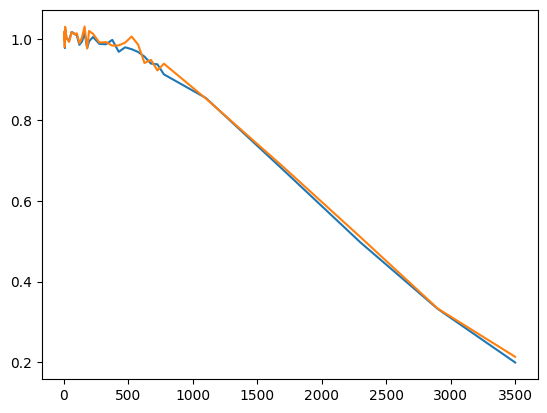

In [9]:
qe_cross = np.load("/users/odarwish/scratch/joint_map_outputs/total_qe_cross_p_p_apo_new_scale_dependent_0.85_apo_new_scale_dependent_0.85_0_63_10.npy")
qe_cross = qe_cross.mean(axis = 0)
qe_cross_split = np.split(qe_cross, len(selected), axis = -1)

qe_input = np.load("/users/odarwish/scratch/joint_map_outputs/input_apo_new_scale_dependent_0.85_apo_new_scale_dependent_0.85_0_63_10.npy")
qe_input = qe_input.mean(axis = 0)

qe_cross_0 = np.load("/users/odarwish/scratch/joint_map_outputs/total_qe_cross_p_p_apo_new_official_a_disabled_apo_new_0_127_20.npy")
qe_cross_0 = qe_cross_0.mean(axis = 0)
qe_cross_0_split = np.split(qe_cross_0, len(selected), axis = -1)

qe_0_input = np.load("/users/odarwish/scratch/joint_map_outputs/input_apo_new_official_a_disabled_apo_new_0_127_20.npy")
qe_0_input = qe_0_input.mean(axis = 0)

ell = np.arange(0, len(qe_cross_split[0])+1)
ACB = 7
ns = 0.85
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
cls_alpha[0] = 0

el, x = decorator(qe_cross_split[0])
#plt.loglog(el, x, color = "blue")
el, ii = decorator(qe_input[0])
#plt.plot(el, ii, color = "red")
frac = x/ii
plt.plot(el, frac)
#plt.loglog(hp.alm2cl(a), ls = "--")
#plt.plot(inputs[0], color = "black")
#plt.plot(cls_alpha, lw = 2, ls = "--")

el, x = decorator(qe_cross_0_split[0])
#plt.loglog(el, x, color = "green")
el, ii = decorator(qe_0_input[0])
#plt.plot(el, ii, color = "cyan")
frac = x/ii
plt.plot(el, frac)

In [9]:
ngg = np.loadtxt(f"n_gg_a_QE.txt")[:5001]
ngg_10 = np.loadtxt(f"ngg_a_itr_10.txt")[:5001]


"""ngg = np.loadtxt(f"sodata/n_gg_a_QE.txt")[:5001]
ngg_10 = np.loadtxt(f"sodata/ngg_a_itr_10.txt")[:5001]
"""

ell = np.arange(0, 5001)
ACB = 7
ns = 1.
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
cls_alpha[0] = 0


WFth = cls_alpha/(cls_alpha+ngg)
WFth10 = cls_alpha/(cls_alpha+ngg_10)

/tmp/ipykernel_22286/1697770919.py:12: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)


## Showing differences in N1s

In [9]:
config_paths = ["official", "official_a_disabled"]
config_paths = ["official_a_disabled", "official_lensing_only_a_disabled"]
config_paths = ["official", "official_lensing_only"]


config_paths = [f"configs/{config}.yaml" for config in config_paths]

selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_paths[0])

autos = autoits.mean(axis = 0)
crosses = crossits.mean(axis = 0)
crosses_lensed = crossits_lensed.mean(axis = 0)

inputs = auto_input_its.mean(axis = 0)

autos_split = np.split(autos, len(selected), axis = -1)
cross_split = np.split(crosses, len(selected), axis = -1)
cross_lensed_split = np.split(crosses_lensed, len(selected), axis = -1)

selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_paths[1])

autos = autoits.mean(axis = 0)
crosses = crossits.mean(axis = 0)
crosses_lensed = crossits_lensed.mean(axis = 0)

inputs_d = auto_input_its.mean(axis = 0)

autos_split_d = np.split(autos, len(selected), axis = -1)
cross_split_d = np.split(crosses, len(selected), axis = -1)
cross_lensed_split_d = np.split(crosses_lensed, len(selected), axis = -1)

/scratch/snx3000/odarwish/joint_map_outputs//total_qe_it_cross_lensed_p_p_apo_new_official_apo_new_0_127_20.npy
/scratch/snx3000/odarwish/joint_map_outputs//total_qe_it_cross_lensed_p_p_po_new_official_po_new_0_127_15.npy


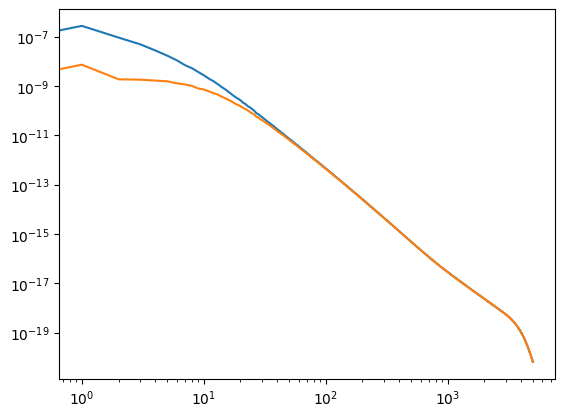

In [10]:
#NO NORMALIZATION

itr = -1


A = autos_split[0][itr]
A_d = autos_split_d[0][itr]
plt.loglog(A) #with rotation effect
plt.loglog(A_d) #without rotation effect

#difference = (A-A_d)

#plt.loglog(difference)

In [11]:
itr = -1
WF = cross_split[0][itr]/inputs[0]
WF_d = cross_split_d[0][itr]/inputs_d[0]

WF = cross_lensed_split[0][itr]/inputs[0]
WF_d = cross_lensed_split_d[0][itr]/inputs_d[0]

#plt.loglog(WF)
#plt.plot(WF_d)

WFth10 = cls_alpha/(cls_alpha+ngg_10*2)
WFth10 = WFth10[:5001]
WF_d = WF #WF_d no rotation

A = autos_split[0][itr]*WF**-2
A_d = autos_split_d[0][itr]*WF_d**-2

el, x = decorator(A_d)
plt.loglog(el, x)

el, xNoise = decorator(A-inputs[0])
plt.loglog(el, xNoise)

plt.plot(ngg_10)

plt.plot(el, -(x-xNoise))


n1_ap = np.loadtxt(f"noise_biases/n1_ap_itr_10.txt")
plt.plot(n1_ap, lw = 2)

n1_aa = np.loadtxt(f"noise_biases/n1_aa_itr_10.txt")
plt.plot(n1_aa, lw = 1)

/tmp/ipykernel_16706/4152334066.py:2: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[0][itr]/inputs[0]
/tmp/ipykernel_16706/4152334066.py:3: RuntimeWarning: invalid value encountered in divide
  WF_d = cross_split_d[0][itr]/inputs_d[0]
/tmp/ipykernel_16706/4152334066.py:5: RuntimeWarning: invalid value encountered in divide
  WF = cross_lensed_split[0][itr]/inputs[0]
/tmp/ipykernel_16706/4152334066.py:6: RuntimeWarning: invalid value encountered in divide
  WF_d = cross_lensed_split_d[0][itr]/inputs_d[0]


NameError: name 'cls_alpha' is not defined

/tmp/ipykernel_1090/3064449184.py:2: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[0][itr]/inputs[0]
/tmp/ipykernel_1090/3064449184.py:3: RuntimeWarning: invalid value encountered in divide
  WF_d = cross_split_d[0][itr]/inputs_d[0]
/tmp/ipykernel_1090/3064449184.py:5: RuntimeWarning: invalid value encountered in divide
  WF = cross_lensed_split[0][itr]/inputs[0]
/tmp/ipykernel_1090/3064449184.py:6: RuntimeWarning: invalid value encountered in divide
  WF_d = cross_lensed_split_d[0][itr]/inputs_d[0]


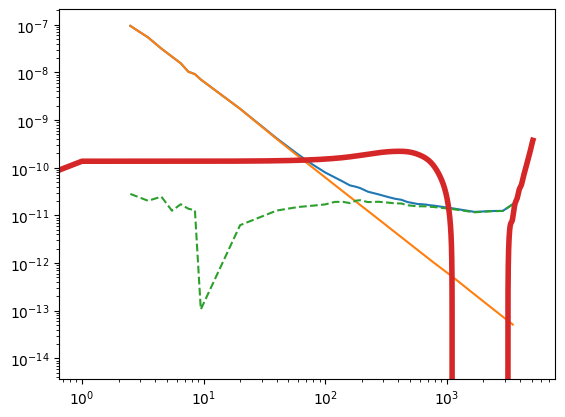

In [30]:
itr = -1
WF = cross_split[0][itr]/inputs[0]
WF_d = cross_split_d[0][itr]/inputs_d[0]

WF = cross_lensed_split[0][itr]/inputs[0]
WF_d = cross_lensed_split_d[0][itr]/inputs_d[0]

#plt.loglog(WF)
#plt.plot(WF_d)

WF_d = WF #WF_d no rotation

A = autos_split[0][itr]*WF**-2
A_d = autos_split_d[0][itr]*WF_d**-2
#plt.loglog(A)

difference = (A-A_d)#with rotation minus without rotation

#plt.loglog(difference)
plt.loglog(*decorator(difference))

plt.plot(*decorator(inputs[0]))

difference = (A-A_d-inputs[0])#with rotation minus without rotation
plt.loglog(*decorator(difference), ls = "--")

"""n1_aa = np.loadtxt(f"noise_biases/n1_aa_itr_10.txt")
plt.plot(n1_aa, lw = 2)
n1_aa = np.loadtxt(f"noise_biases/n1_aa_QE.txt")
plt.plot(n1_aa, lw = 2, ls = "--")

n1_aa = np.loadtxt(f"noise_biases/n1_ap_itr_10.txt")
plt.plot(n1_aa, lw = 4)
n1_aa = np.loadtxt(f"noise_biases/n1_ap_QE.txt")
plt.plot(n1_aa, lw = 4, ls = "--")"""

n1_aa = np.loadtxt(f"noise_biases/n1_ap_itr_10.txt")
plt.plot(n1_aa, lw = 4)


## Studying WF

/scratch/snx3000/odarwish/joint_map_outputs//total_qe_it_cross_lensed_p_p_apo_new_official_check_factor_2_apo_new_0_64_10.npy


/tmp/ipykernel_22286/2984547896.py:20: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[ii][itr]/inputs[ii]
/tmp/ipykernel_22286/2984547896.py:21: RuntimeWarning: invalid value encountered in divide
  WF_lensed = cross_lensed_split[ii][itr]/inputs[ii]


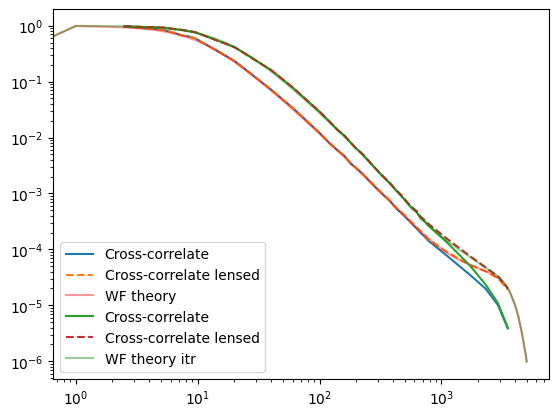

In [20]:
config_paths = ["official_check_factor_2"] #["official"] #["official_so_a_disabled"]#["official"] #["official_a_disabled"]#, "official"]#, "official_a_disabled", "official_a_disabled_scale_dependent"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

ii = 0

for j, config_path in enumerate(config_paths):
    selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_path)

    autos = autoits.mean(axis = 0)
    crosses = crossits.mean(axis = 0)
    crosses_lensed = crossits_lensed.mean(axis = 0)

    inputs = auto_input_its.mean(axis = 0)

    autos_split = np.split(autos, len(selected), axis = -1)
    cross_split = np.split(crosses, len(selected), axis = -1)
    cross_lensed_split = np.split(crosses_lensed, len(selected), axis = -1)

    for itr in [0, 10]:
        WF = cross_split[ii][itr]/inputs[ii]
        WF_lensed = cross_lensed_split[ii][itr]/inputs[ii]

        #plt.loglog(WF, ls = "-" if j == 0 else "--")
        el, WF = decorator(WF)
        plt.loglog(el, WF, ls = "-" if j == 0 else "--", label = "Cross-correlate")

        el, WF_lensed = decorator(WF_lensed)
        plt.loglog(el, WF_lensed, ls = "--" if j == 0 else "--", label = "Cross-correlate lensed")

        if itr == 0:
            plt.loglog(WFth, color = "red", alpha = 0.4, label = "WF theory")
        else:
            WFth10 = cls_alpha/(cls_alpha+ngg_10)
            plt.loglog(WFth10, color = "green", alpha = 0.4, label = "WF theory itr")

    plt.legend()


## Randomized noise

In [13]:
config_paths = ["official", "official_a_disabled", "official_so_a_disabled", "official", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]


#config_paths = config_paths[1:]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

socase = "so" in config_paths[0]

label = "so" if socase else "s4"
dir = "sodata/" if socase else ""
direc = "_so" if socase else ""

ngg = np.loadtxt(f"{dir}n_gg_a_QE.txt")[:5001]

ngg_10 = np.loadtxt(f"{dir}ngg_a_itr_10.txt")[:5001]

#n1_ap = np.loadtxt(f"{dir}n1_ap.txt")[:5001]
#ngg_unl = np.loadtxt(f"{dir}ngg_a_itr_unl.txt")[:5001]

In [14]:
config_paths = ["official_a_disabled", "official_a_disabled", "official_so_a_disabled", "official", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_paths[0])


autos = autoits.mean(axis = 0)
crosses = crossits.mean(axis = 0)
crosses_lensed = crossits_lensed.mean(axis = 0)
inputs = auto_input_its.mean(axis = 0)

stdautos = autoits.std(axis = 0)

autos_split_full = np.split(autos, len(selected), axis = -1)
cross_split = np.split(crosses, len(selected), axis = -1)
crosses_lensed_split =  np.split(crosses_lensed, len(selected), axis = -1)

WFs_full = crosses_lensed/np.concatenate(inputs, axis = 0)#[, :]
WFs_full = np.split(WFs_full, 3, axis = -1)

Nblock = 64
autoits_block1 = autoits[:Nblock, ...]
crossits_block1 = crossits[:Nblock, ...]

autoits_block2 = autoits[Nblock:, ...]
crossits_block2 = crossits[Nblock:, ...]
autoits_block2m = autoits_block2.mean(axis = 0)
crossits_block2m = crossits_block2.mean(axis = 0)

autoits_block2_split = np.split(autoits_block2m, len(selected), axis = -1)
crossits_block2_split = np.split(crossits_block2m, len(selected), axis = -1)

autos = autoits_block1.mean(axis = 0)
crosses = crossits_block1.mean(axis = 0)
inputs = auto_input_its.mean(axis = 0)

stdautos = autoits.std(axis = 0)

autos_split = np.split(autos, len(selected), axis = -1)
cross_split = np.split(crosses, len(selected), axis = -1)

WFs = crosses/np.concatenate(inputs, axis = 0)#[, :]
WFs = np.split(WFs, 3, axis = -1)

itr_ = 10
N1plot = np.loadtxt(f"N1s_{itr_}.txt")
N0plot = np.loadtxt(f"N0s_{itr_}.txt")

/scratch/snx3000/odarwish/joint_map_outputs//total_qe_it_cross_lensed_p_p_apo_new_official_a_disabled_apo_new_0_127_20.npy


/tmp/ipykernel_22286/1537021908.py:18: RuntimeWarning: invalid value encountered in divide
  WFs_full = crosses_lensed/np.concatenate(inputs, axis = 0)#[, :]
/tmp/ipykernel_22286/1537021908.py:42: RuntimeWarning: invalid value encountered in divide
  WFs = crosses/np.concatenate(inputs, axis = 0)#[, :]


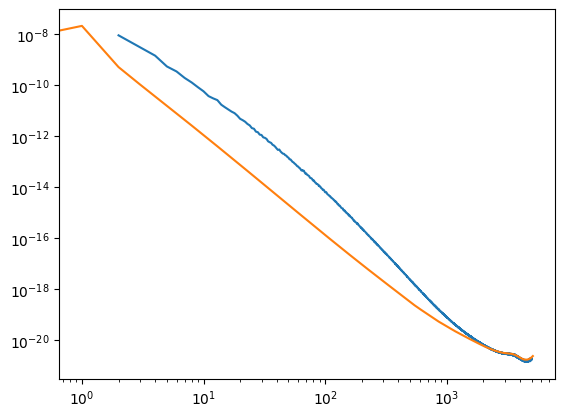

In [15]:
source = 1
itr = -1
plt.loglog(autoits_block2_split[source][itr]*WFs[source][itr]**-2.)
plt.plot(N0plot)

In [16]:
ngg_a_itr_unl = np.loadtxt("ngg_a_itr_unl.txt")

In [42]:
dirij = "/users/odarwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apo_new_official_check_factor_2_recs/p_p_sim0000apo_new_official_check_factor_2/"

idxs = range(3)
ii = 0

tv = []
zv = []
wv = []
xv = []
av = []
bv = []
cv = []

coadd = []

itrmax = 15

for idx in idxs:
    plm_ij = np.load(f"{dirij}/plm_N0p{itrmax:03}_i_j_v2_sim{idx:04}.npy")
    plm_ii = np.load(f"{dirij}/plm_N0p{itrmax:03}_i_i_v2_sim{idx:04}.npy")
    plm_jj = np.load(f"{dirij}/plm_N0p{itrmax:03}_j_j_v2_sim{idx:04}.npy")
    plm_ji = np.load(f"{dirij}/plm_N0p{itrmax:03}_j_i_v2_sim{idx:04}.npy")

    plm_ij = np.split(plm_ij, 3)[ii]
    plm_ji = np.split(plm_ji, 3)[ii]
    plm_ii = np.split(plm_ii, 3)[ii]
    plm_jj = np.split(plm_jj, 3)[ii]


    t = hp.alm2cl(plm_ij, plm_ji)+hp.alm2cl(plm_ij)
    tv.append(t)
    z = hp.alm2cl((plm_ji+plm_ij)*0.5)
    zv.append(z)
    w = hp.alm2cl(plm_ji)
    wv.append(w)
    x = hp.alm2cl(plm_ij)
    xv.append(x)

    a = hp.alm2cl(plm_ii)
    av.append(a)
    b = hp.alm2cl(plm_jj)
    bv.append(b)
    c = hp.alm2cl(plm_ii, plm_jj)
    cv.append(c)


    plm_dd = np.load(f"{dirij}/plm_N0p{itrmax:03}_d_d_v2_sim{idx:04}.npy")
    plm_dd = np.split(plm_dd, 3)[ii]

    plm_di = np.load(f"{dirij}/plm_N0p{itrmax:03}_d_i_v2_sim{idx:04}.npy")
    plm_di = np.split(plm_di, 3)[ii]

    plm_id = np.load(f"{dirij}/plm_N0p{itrmax:03}_i_d_v2_sim{idx:04}.npy")
    plm_id = np.split(plm_id, 3)[ii]

    plm_coadd = (plm_id+plm_di)/2
    plm_ij_coadd = (plm_ij+plm_ji)/2
    coadd.append(hp.alm2cl(plm_ij_coadd))

am = np.mean(av, axis = 0)
bm = np.mean(bv, axis = 0)
cm = np.mean(cv, axis = 0)
tm = np.mean(tv, axis = 0)
zm = np.mean(zv, axis = 0)
wm = np.mean(wv, axis = 0)
xm = np.mean(xv, axis = 0)
coadd = np.mean(coadd, axis = 0)


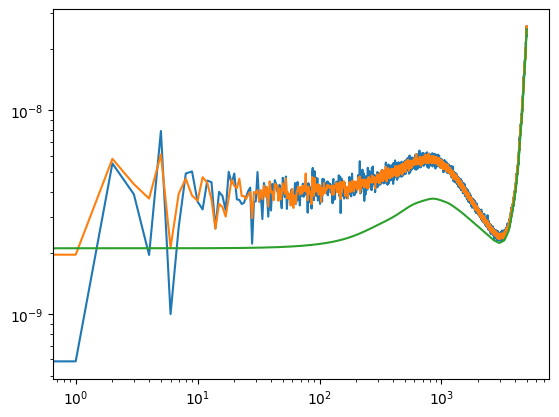

In [44]:
#cl = 4*hp.alm2cl(plm_id)-2*hp.alm2cl(plm_ij)
#plt.loglog((4*hp.alm2cl(plm_coadd)-2*hp.alm2cl(plm_ij_coadd))*(N0**2)[:5001])

plt.loglog((hp.alm2cl(plm_ij_coadd))*(N0**2)[:5001])


N0 = ngg_10 if ii == 0 else N0plot

plt.loglog(coadd*(N0**2)[:5001])
#plt.loglog(clcoadd*(N0**2)[:5001])


#plt.loglog(tm*(N0**2)[:5001])
#plt.loglog(zm*(N0**2)[:5001])
#plt.loglog(wm*(N0**2)[:5001])
#plt.loglog(xm*(N0**2)[:5001])
#plt.loglog(am*(N0**2)[:5001])
#plt.loglog(bm*(N0**2)[:5001])
#plt.loglog(cm*(N0**2)[:5001])
plt.plot(N0)

#plt.loglog(*decorator(hp.alm2cl(plm_ji, plm_ij)*N0[:5001]**2))

source = ii
#plt.loglog(autoits_block2_split[source][itr]*WFs_full[source][itr]**-2.)


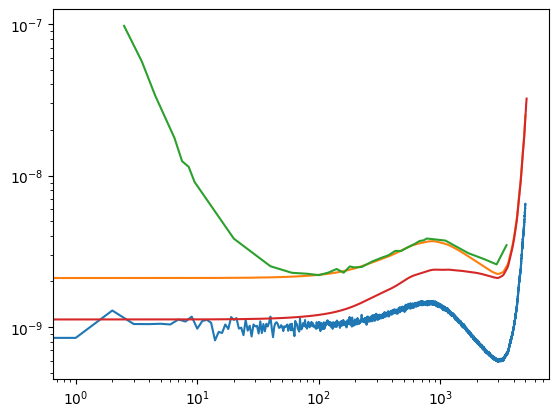

In [77]:
NN = 5
dirij = "/users/odarwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apo_new_official_recs/p_p_sim0000apo_new_official/"
prand = ((np.load(f"{dirij}/plm_N0p020_i_j_sim{idx:04}.npy")+np.load(f"{dirij}/plm_N0p020_j_i_sim{idx:04}.npy")) for idx in range(NN))
ii = 0
cl = np.sum(np.array(list(map(lambda x: hp.alm2cl(np.split(x, 3)[ii]).squeeze(), prand))), axis = 0)/NN

if ii == 0:
    plt.loglog(0.5*cl*ngg_10**2.)
    plt.plot(ngg_10)

    source = ii
    itr = -1

    
    #plt.plot(autoits_block2_split[source][itr]*WFs[source][itr]**-2.)


    plt.plot(*decorator(autos_split_full[source][itr]*WFs_full[source][itr]**-2.))

    plt.plot(ngg_a_itr_unl)
else:
    N0plot = np.loadtxt(f"N0s_10.txt")
    plt.loglog(0.5*cl*(N0plot**2)[:5001])
    plt.plot(N0plot)
    #plt.plot(autoits_block2_split[1][-1]*WFs[1][itr]**-2.)

## Noise improvements plots

/scratch/snx3000/odarwish/joint_map_outputs//total_qe_it_cross_lensed_p_p_apo_new_official_check_factor_2_apo_new_0_63_15.npy


/tmp/ipykernel_22286/3498593816.py:41: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[i][itr]/inputs[i]
/tmp/ipykernel_22286/3498593816.py:87: RuntimeWarning: divide by zero encountered in power
  xx = autos_split[i][itr]*WFth**-2.-inputs[i]-ngg[:5001]
/tmp/ipykernel_22286/3498593816.py:87: RuntimeWarning: invalid value encountered in multiply
  xx = autos_split[i][itr]*WFth**-2.-inputs[i]-ngg[:5001]
/tmp/ipykernel_22286/3498593816.py:109: RuntimeWarning: divide by zero encountered in power
  xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]
/tmp/ipykernel_22286/3498593816.py:109: RuntimeWarning: invalid value encountered in multiply
  xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]
/tmp/ipykernel_22286/3498593816.py:119: RuntimeWarning: divide by zero encountered in power
  xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001]
/tmp/ipykernel_22286/3498593816.py:119: RuntimeWarning: invalid value encountered in multiply
  xx = autos_split[i][itr]*WFnorm**-2.-

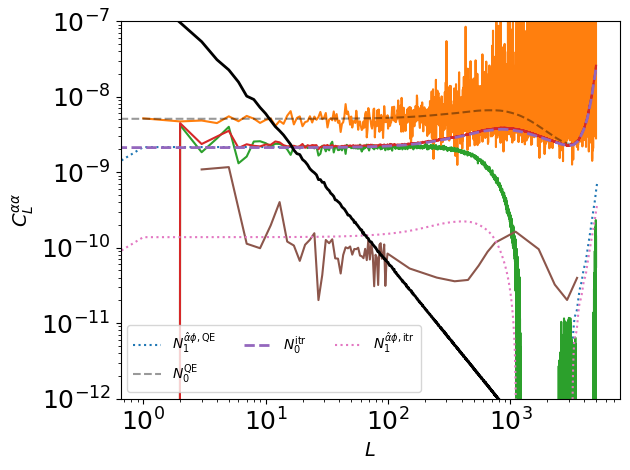

/scratch/snx3000/odarwish/joint_map_outputs//total_qe_it_cross_lensed_p_p_apo_new_official_check_factor_2_apo_new_0_63_15.npy


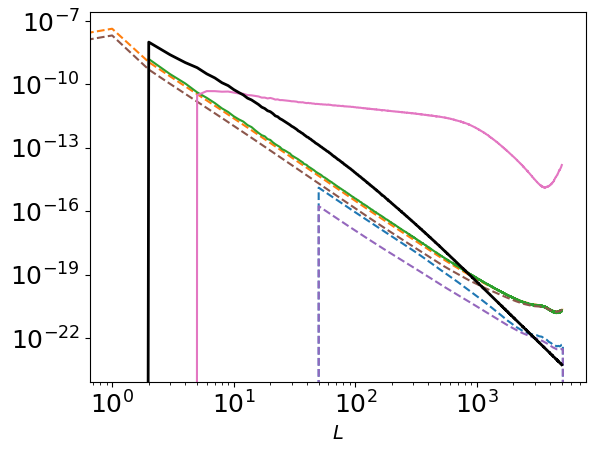

/scratch/snx3000/odarwish/joint_map_outputs//total_qe_it_cross_lensed_p_p_apo_new_official_check_factor_2_apo_new_0_63_15.npy


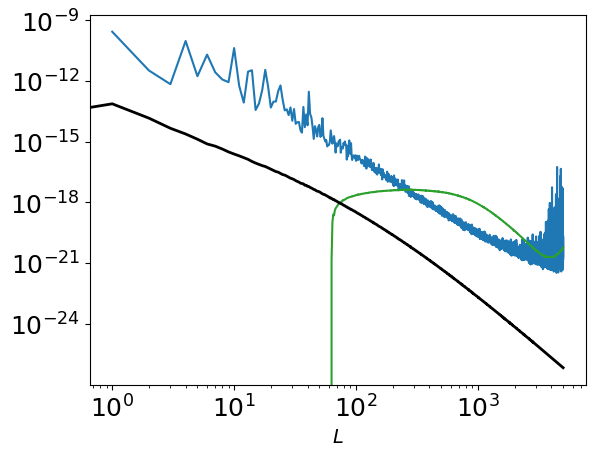

In [51]:
selected = ['a', 'p', 'o']

invWFs = {}

config_paths = ["official_check_factor_2", "official_a_disabled", "official_a_disabled", "official_so_a_disabled", "official", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]


bin_edges_B = np.arange(2, 100, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])


bin_edges_B = np.arange(2, 100, 2)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])

decorator = lambda x: bin_theory(x, bin_edges)


for i, s in enumerate(selected):
    for j, config_path in enumerate(config_paths[:1]):
        selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_path)

        autos = autoits.mean(axis = 0)
        crosses = crossits.mean(axis = 0)
        inputs = auto_input_its.mean(axis = 0)

        stdautos = autoits.std(axis = 0)

        autos_split = np.split(autos, len(selected), axis = -1)
        cross_split = np.split(crosses, len(selected), axis = -1)

        """plt.loglog(cross_split[0][0]*WFth**-1.)

        plt.loglog(cross_split[0][-1]*WFth10**-1.)

        plt.loglog(inputs[0])
        plt.show()"""

        for itr in [0, autos.shape[0]-1]:
    
            WF = cross_split[i][itr]/inputs[i]
            el, WF_ = decorator_WF(WF)
            import scipy.interpolate
            WFf = scipy.interpolate.interp1d(el, WF_, kind = "linear", fill_value = "extrapolate")
            ls = np.arange(100, 5001)
            WFinterp = WFf(ls)
            WFother = WF.copy()
            WFother[100:] = WFinterp
            
            if itr == 0:
                WFQE = WF
            invWF = WF**-1.
            if j == 0:
                invWFs[s] = invWF
            #xx = autos_split[i][itr]*invWFs[s]**2.-inputs[i]

            if i == 1:
                itr_ = 10 if itr in [15, 20] else itr
                N1plot = np.loadtxt(f"N1s_{itr_}.txt")
                N0plot = np.loadtxt(f"N0s_{itr_}.txt")
                plt.loglog(N1plot, ls = "--")
                plt.plot(N0plot, ls = "--")
                if itr == 20:
                    xx = autos_split[i][itr]*WF**-2.-inputs[i]-N0plot[:5001]
                    plt.loglog(xx)


            if itr == 0:

                if i == 0:
                    n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_QE.txt")
                    plt.loglog(n1_ap, label = r"$N_1^{\hat{\alpha}\phi, \mathrm{QE}}}$", ls = ":")


                xx = autos_split[i][itr]*WF**-2.-inputs[i]-n1_ap[:5001]*(i == 0)
                plt.loglog(xx)

                #n1_aa = np.loadtxt(f"noise_biases{direc}/n1_aa_QE.txt")
                #plt.loglog(n1_aa, ls = "--")
                el, x = decorator(xx)
                
                #plt.plot(autos_split[i][itr]*WFth**-2.-nggs["a"][:5001]-inputs[i], color = "green")
               # plt.plot(autos_split[i][itr]*WFth**-2., color = "green")
                #plt.plot(el, x, lw = 2, label = r"$C_L^{\hat{\alpha}^{\mathrm{QE}}\hat{\alpha}^{\mathrm{QE}}}-C_L^{\alpha\alpha}-N_1^{\hat{\alpha}\phi}$")

                xx = autos_split[i][itr]*WFth**-2.-inputs[i]-ngg[:5001]
                el, x = decorator(xx)
                plt.plot(xx)

                if i == 0:
                    plt.plot(ngg, color = "black", alpha = 0.4, label = r"$N_0^{\mathrm{QE}}$", ls = "--")
                
                #el, xy = decorator(autos_split[i][itr]*invWFs[s]**2.)
                #el, xy = decorator(autos_split[i][itr]*WFth**-2.)
                #plt.plot(el, xy, label = "WF normalized")
                #np.savetxt("x.txt", np.c_[el, xy])

                
                #el, xy = decorator(qe_alpha)
                #plt.plot(el, xy, ls = "--", label = "QE normalized")

            else:

                WFnorm = WFth10
                #WFnorm = WFother
                WFnorm = WF
                
                xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]
                plt.plot(xx)
                el, x = decorator(xx)
                #plt.plot(el, x, color = "brown", label = r"$C_L^{\hat{\alpha}^{\mathrm{QE}}\hat{\alpha}^{\mathrm{QE}}}-C_L^{\alpha\alpha}$")
                #el, x = decorator(autos_split[i][itr]*WF**-2.)
                #plt.plot(el, x, color = "red", ls = "--")
                if i == 0:
                    plt.plot(ngg_10, lw = 2, label = r"$N_0^{\mathrm{itr}}$", ls = "--")

                if i == 0:
                    xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001]
                    el, x = decorator(autos_split[i][itr]*WFth10**-2.-inputs[i]-ngg_10[:5001])
                    plt.loglog(el, x)
                    #plt.plot(el, x, marker = "o")

                if i == 0:
                    n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_itr_10.txt")
                    plt.loglog(n1_ap, label = r"$N_1^{\hat{\alpha}\phi, \mathrm{itr}}}$", ls = ":")

                #n1_aa = np.loadtxt(f"noise_biases{direc}/n1_aa_itr_10.txt")
                #plt.loglog(n1_aa, ls = ":")

    

        plt.plot(inputs[i], color = "black", lw = 2)#, label = r"$C_L^{\alpha\alpha}$")
        #plt.plot(nggs[s], lw = 2)
        #plt.plot(n0_bb)
        #plt.title(s)
        #print(a)
        #plt.xlim(5, 2000)
        #plt.savefig("")
        plt.yticks(fontsize = 18)
        
        plt.xticks(fontsize = 18)
        plt.xlabel(r"$L$", fontsize = 14)
    if s == "a":
        plt.ylabel(r"$C_L^{\alpha\alpha}$", fontsize = 14)
        if socase:
            #plt.ylim(1e-8, 5e-7)
            pass
        else:
            pass
        plt.ylim(1e-12, 1e-7)
        plt.tight_layout()
        plt.xscale("log")
        plt.yscale("log")
        #plt.xlim(5, 500)
        plt.legend(ncol = 3, fontsize = 10)
        #plt.savefig(f"/users/odarwish/JointCMBiterative/figures/examples/alpha_improvements_{label}.pdf", dpi = 300)
    plt.show()

In [52]:
xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001]
el, x = decorator(autos_split[i][itr]*WFth10**-2.-inputs[i]-ngg_10[:5001])

noise_10 = np.sqrt(WFnorm)**-1.*ngg_10[:5001]

/tmp/ipykernel_22286/2121542967.py:1: RuntimeWarning: divide by zero encountered in power
  xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001]
/tmp/ipykernel_22286/2121542967.py:1: RuntimeWarning: invalid value encountered in multiply
  xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001]
/tmp/ipykernel_22286/2121542967.py:2: RuntimeWarning: divide by zero encountered in power
  el, x = decorator(autos_split[i][itr]*WFth10**-2.-inputs[i]-ngg_10[:5001])
/tmp/ipykernel_22286/2121542967.py:2: RuntimeWarning: invalid value encountered in multiply
  el, x = decorator(autos_split[i][itr]*WFth10**-2.-inputs[i]-ngg_10[:5001])
/tmp/ipykernel_22286/2121542967.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  noise_10 = np.sqrt(WFnorm)**-1.*ngg_10[:5001]


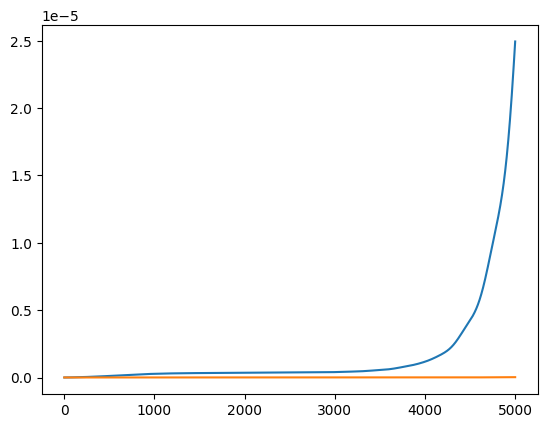

In [53]:
plt.plot(noise_10)
plt.plot(ngg_10)

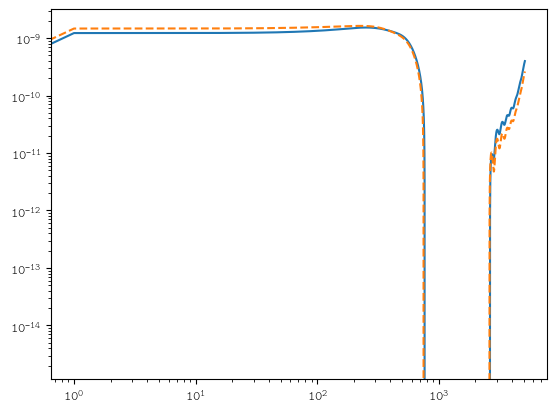

In [52]:
n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_itr_10.txt")
plt.loglog(n1_ap)
n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_QE.txt")
plt.loglog(n1_ap/2, ls = "--")

In [29]:
cross_phi = {0: {0: [], 15: []}, 1: {0: [], 15: []}}

def plot_configs_with_class(config_paths, subset_selected, itrs, outname):
    config_data = [process_config_npy(config_path) for config_path in config_paths]

    N_configs = len(config_paths)
    rows = len(subset_selected)
    cols = N_configs

    names_fields = {"p": r"$\phi$", "o": r"$\omega$", "f": r"$\tau$", "a": r"$\alpha$"}

    # Initialize CMBLensingPlot
    plot = CMBLensingPlot(rows=rows, cols=cols, figsize=(10, 6), sharex=True, sharey = False, outdir = "../plots/")

    for j, (selected, autoits, crossits, auto_input_its, crossits_down, auto_input_down_its) in enumerate(config_data):  # Iterate over configurations
            
            autos = autoits.mean(axis = 0)
            crosses = crossits.mean(axis = 0)
            inputs = auto_input_its.mean(axis = 0)

            crosses_down = crossits_down.mean(axis = 0)
            inputs_down = auto_input_down_its.mean(axis = 0)

            stdautos = autoits.std(axis = 0)

            autos_split = np.split(autos, len(selected), axis = -1)
            cross_split = np.split(crosses, len(selected), axis = -1)

            cross_down_split = np.split(crosses_down, len(selected), axis = -1)

            for i, k in enumerate(subset_selected):  # Iterate over estimators

                original_idx = selected.index(k)
            
                for idx, itr in enumerate(itrs):  # Iterate over iterations
                    
                    el, cross = cross_corr_coeff_from_cl(autos_split[original_idx][itr], inputs[original_idx], cross_split[original_idx][itr], plot=False)

                    if k=="p":
                         cross_phi[j][itr] = autos_split[original_idx][itr]

                    el, cross_down = cross_corr_coeff_from_cl(autos_split[original_idx][itr], inputs_down[original_idx], cross_down_split[original_idx][itr], plot=False)
                    plot.add_curve(el, cross, label=f"itr {itr}", row=i, col=j, linewidth = 1.5)
                    plot.add_curve(el, cross_down, label=f"itr {itr}", row=i, col=j, linewidth = 1.5, linestyle="--")

                plot.set_labels(xlabel=r"$L$", ylabel=r"$\rho_L$" + f"({names_fields[k]})", row=i, col=j)
                plot.set_xlim(xmin = 5, xmax = 1000, row = i, col = j)

                plot.set_scale(xscale="log", row=i, col=j)
                """if k == "a":
                     plot.set_ylim(row = i, col = j, ymin = 0, ymax = 0.6)
                elif k == "o":
                    plot.set_ylim(row = i, col = j, ymin = 0, ymax = 0.3)"""
                if i == 0:
                    plot.set_title(k, row=i, col=j)
                    if j == 0:
                        plot.set_legend(row=i, col=j, fontsize = 10)

    #plot.save_plot(outname, dpi=300)
    plot.show_plot()

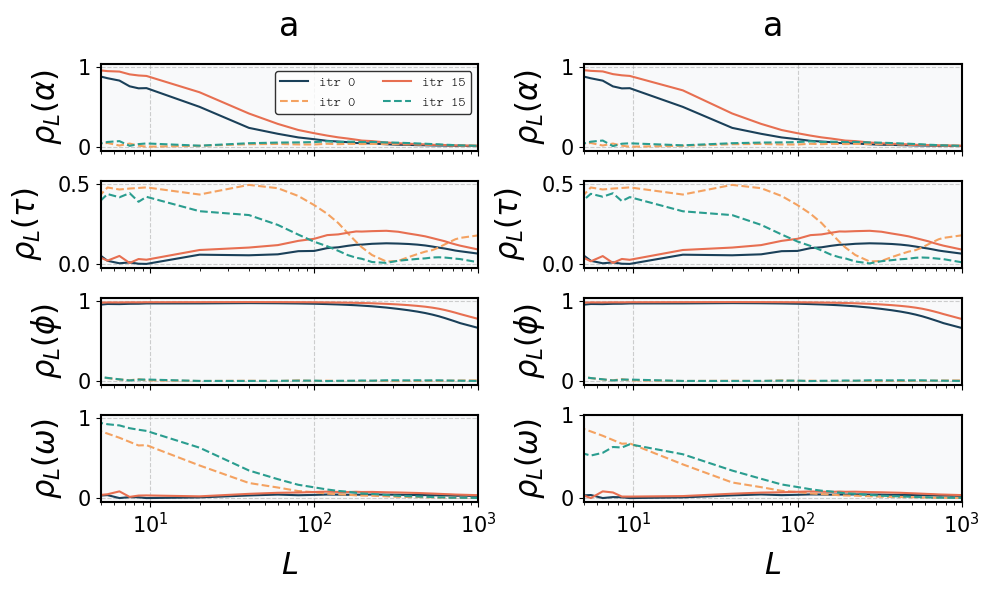

In [30]:
config_paths = ["official_multiple_disabled",  "official_multiple", "official_deep_multiple", "official_multiple", "official_multiple_disabled", "official_so_a_disabled", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]
config_paths = config_paths[:2]

subset_selected = ["a", "f", "p", "o"]
itrs = [0, 15]#, 15]
outname = ""
plot_configs_with_class(config_paths, subset_selected, itrs, outname)

In [31]:
cross_phi

{0: {0: array([0.00000000e+00, 0.00000000e+00, 7.87969107e-09, ...,
         1.61770824e-26, 1.61511759e-26, 1.61331630e-26]),
  15: array([0.00000000e+00, 0.00000000e+00, 7.75256360e-09, ...,
         1.54413683e-26, 1.54466070e-26, 1.54153783e-26])},
 1: {0: array([0.00000000e+00, 0.00000000e+00, 7.87969108e-09, ...,
         1.61770824e-26, 1.61511759e-26, 1.61331630e-26]),
  15: array([0.00000000e+00, 0.00000000e+00, 6.51813693e-09, ...,
         1.54412751e-26, 1.54463366e-26, 1.54153951e-26])}}

/tmp/ipykernel_26833/3116759026.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(cross_phi[0][15]/cross_phi[1][15])


(0.95, 1.05)

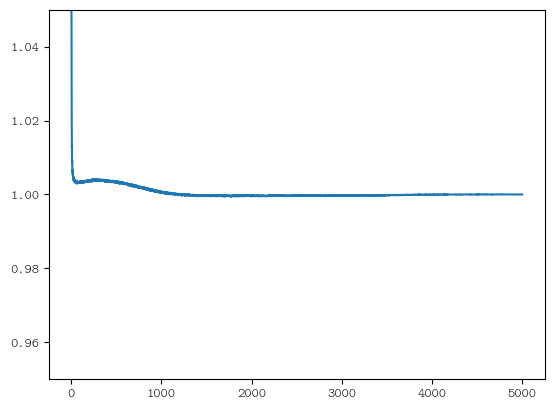

In [35]:
plt.plot(cross_phi[0][15]/cross_phi[1][15])
plt.ylim(0.95, 1.05)